In [1]:
import numpy as np
import scipy as sp
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import altair as alt
from altair.expr import datum
alt.renderers.enable('default')
from altair_widgets import interact_with

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

from datetime import datetime
from dateutil.relativedelta import relativedelta

# Data loading and preliminary wrangling  

In [17]:
df_test = pd.read_csv('ab_data.csv',parse_dates=['timestamp'], index_col='user_id')
df_test.head()

,timestamp,group,landing_page,converted
user_id,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0
804228,2017-01-12 08:01:45.159739,control,old_page,0
661590,2017-01-11 16:55:06.154213,treatment,new_page,0
853541,2017-01-08 18:28:03.143765,treatment,new_page,0
864975,2017-01-21 01:52:26.210827,control,old_page,1


In [18]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294478 entries, 851104 to 715931
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   timestamp     294478 non-null  datetime64[ns]
 1   group         294478 non-null  object        
 2   landing_page  294478 non-null  object        
 3   converted     294478 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 11.2+ MB


In [4]:
df_test.timestamp.agg([min,max])

min   2017-01-02 13:42:05.378582
max   2017-01-24 13:41:54.460509
Name: timestamp, dtype: datetime64[ns]

In [5]:
df_test.isna().sum()

timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [6]:
df_test.groupby(['group','landing_page']).count()

timestamp  converted
group     landing_page                      
control   new_page           1928       1928
          old_page         145274     145274
treatment new_page         145311     145311
          old_page           1965       1965

<font color="darkred">
    <font size="3"> 
        Thus, there were the  users in the control group that saw the new web page and vice versa.
        According to the rules of the A/B test, the control group should receive only "old page", while the test group receives "new page" only. 
        Since there is no additional information to determine which users are misclassified and correct them, the incorrect data should be removed from the analysis.
    </font>
</font>


In [7]:
df_clean = df_test.loc[(df_test.group == 'control') & (df_test.landing_page == 'old_page') | (df_test.group == 'treatment') & (df_test.landing_page == 'new_page')]

In [8]:
df_clean.groupby(['group','landing_page']).count()

,,timestamp,converted
group,landing_page,,
control,old_page,145274,145274
treatment,new_page,145311,145311


Check for duplicate values based on user_id:

In [9]:
df_clean.index.duplicated().sum()

1

In [10]:
df_clean[df_clean.index.duplicated(keep=False)]

,timestamp,group,landing_page,converted
user_id,,,,
773192,2017-01-09 05:37:58.781806,treatment,new_page,0
773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [11]:
'''Drop out duplicate user_id, keep the first entry '''

df_clean.reset_index(inplace=True)
df_clean.drop_duplicates(subset=['user_id'],keep='first',inplace=True)

# Exploratory Data Analysis

In [14]:
df_clean.groupby(['group','landing_page','converted']).size().to_frame(name='size')

size
group     landing_page converted        
control   old_page     0          127785
                       1           17489
treatment new_page     0          128046
                       1           17264

<AxesSubplot:ylabel='landing_page'>

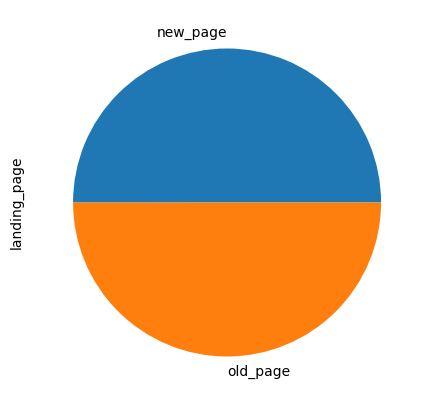

In [15]:
df_clean.landing_page.value_counts().plot.pie(figsize=(10,5))

In [16]:
''' Cross table'''
pd.crosstab([df_clean.group,df_clean.landing_page],df_clean.converted,margins=True)

,converted,0,1,All
group,landing_page,,,
control,old_page,127785,17489,145274
treatment,new_page,128046,17264,145310
All,,255831,34753,290584


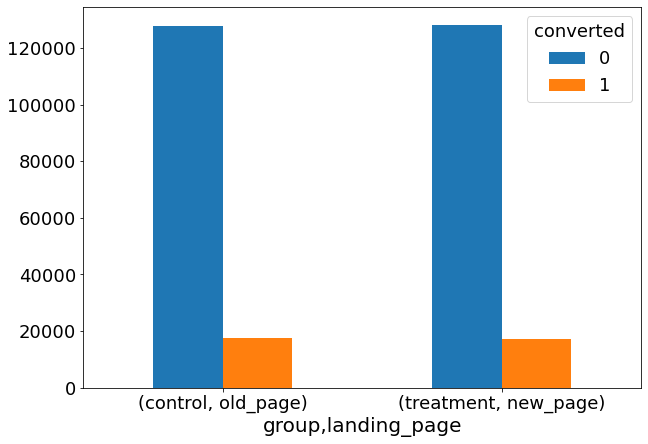

In [175]:
fig = pd.crosstab([df_clean.group,df_clean.landing_page],df_clean.converted).plot.bar(figsize=(10,7),rot=0,fontsize=18)
fig.legend(title='converted',title_fontsize=18,fontsize=18)
fig.xaxis.label.set_size(20)

In [198]:
pd.pivot_table(data=df_clean,index=['group','landing_page'],columns=['converted'],aggfunc='size',)

,converted,0,1
group,landing_page,,
control,old_page,127785,17489
treatment,new_page,128046,17264


In [22]:
df_clean.groupby('group').timestamp.agg([min,max])

,min,max
group,,
control,2017-01-02 13:42:15.234051,2017-01-24 13:41:54.460509
treatment,2017-01-02 13:42:05.378582,2017-01-24 13:41:44.097174


This shows that investigation was conducted at the same time for 2 groups as it should be. 

# The analysis of the result and the test of significance (Pearson's chi-squared test)

We are dealing with discrete case, e.g. click-though rate. In this case there are 2 main methods to evaluase the statisctical signigicance of the results: 
Fisher's exact test and Pearson's chi-squared test. In practice, the first method is used when the sample size is small because it is computationally expensive.
Although Fisher's exact test has the important advantage of computing exact p-values, since the dataset we consider is not small, we will use Pearson's chi-squared test to compute an approximate p-value:

$$
\chi^2 = \sum_{i=1}^{2} \sum_{j=1}^{2} \frac{(x_{ij} - E_{ij})^2}{E_{ij}}, \qquad E_{ij} = \frac{(x_{i1} + x_{i2})(x_{1j} + x_{2j})}{x_{11} + x_{12} + x_{21} + x_{22}}
$$

Build the crosstab again: 

In [47]:
df_cross = pd.crosstab(df_clean.landing_page, df_clean.converted)
df_cross

converted,0,1
landing_page,,
new_page,128046,17264
old_page,127785,17489


Calculate the conversion rate for two groups and compare the results: 

In [67]:
new_CR = df_cross.loc['new_page', 1]/df_cross.loc['new_page', :].sum()
old_CR = df_cross.loc['old_page', 1]/df_cross.loc['old_page', :].sum()
print(f'new page conversion rate is {new_CR: .4f} \n'
      f'old page conversion rate is {old_CR: .4f}')

new page conversion rate is  0.1188 
old page conversion rate is  0.1204


So the difference in conversion rate between two groups is negligible, but let's conduct the statistical significance check of the results using chi2 test: 

In [79]:
chi2stat, pval, _, _ = sp.stats.chi2_contingency(df_cross,correction=False)
print("- Pearson's chi-squared test:\n"
      f'   - χ2 value:\t {chi2stat:.3f} \n'
      f'   - p-value:\t {pval*100:.1f}%')

- Pearson's chi-squared test:
   - χ2 value:	 1.719 
   - p-value:	 19.0%


<font color="darkred">
    <font size="3"> 
        The p values obtained using the Chi2 test are 19%, which exceeds the standard significance limit of 5%.        
        Therefore, there is no obvious reason to reject the null hypothesis of identical distributions. 
        Or, to put it simply, there is no statistical significance in the conversion between the old and new web page.
    </font>
</font>